In [1]:
import os
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL
import matplotlib.pyplot as plt
import time
from datetime import datetime

This code loads the Stable Diffusion model with LoRA weights obtained from the file LoRA.ipynb, optimizes it for GPU using float16 precision, and generates high-quality images based on specified text prompts (with increased resolution and number of inference steps). For each prompt, a separate folder is created where the generated images are saved with unique filenames, including a timestamp. Memory optimizations such as attention slicing and model offloading to the CPU are enabled when necessary.

Используемое устройство: cuda


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\spark\PycharmProjects\MyFirstPtoject\ArtGenerationLoRA_SD2\.venv\Lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/50 [00:00<?, ?it/s]

Время генерации для промпта 'Draw a dark horse in the style of <artg> with lots of detail. A horse on a dark watercolor background': 20.83 секунд
Сохранено изображение: model_results\Draw_a_dark_horse_in_the_style_of_artg_with_lots_o\generated_20241011_104954_1.png
Сохранено изображение: model_results\Draw_a_dark_horse_in_the_style_of_artg_with_lots_o\generated_20241011_104954_2.png
Сохранено изображение: model_results\Draw_a_dark_horse_in_the_style_of_artg_with_lots_o\generated_20241011_104954_3.png


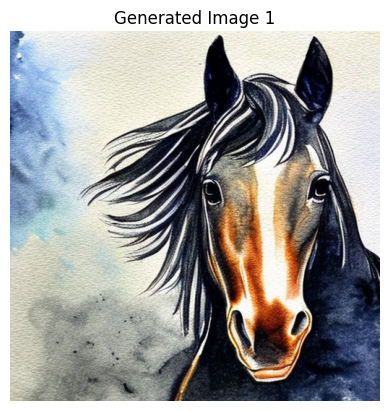

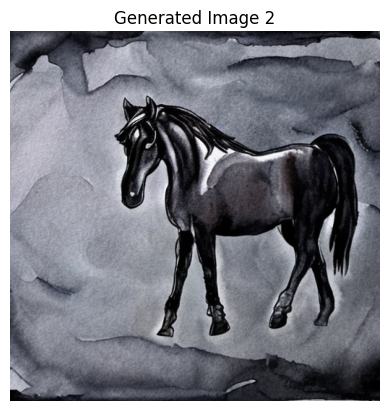

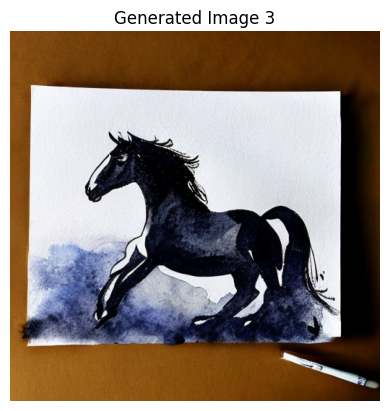

In [2]:
# Функция для сохранения изображений с уникальными именами
def save_images(images, folder, prompt):
    # Очищаем промпт от пробелов и символов для использования в названии папки
    prompt_clean = prompt.replace(" ", "_").replace(".", "").replace(",", "").replace(":", "").replace(";", "").replace("<", "").replace(">", "")[:50]

    # Создаем подкаталог для каждого промпта
    prompt_folder = os.path.join(folder, prompt_clean)
    os.makedirs(prompt_folder, exist_ok=True)

    for i, image in enumerate(images):
        # Генерируем уникальное имя файла на основе времени и промпта
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"generated_{timestamp}_{i+1}.png"
        image_path = os.path.join(prompt_folder, filename)

        # Сохраняем изображение
        image.save(image_path)
        print(f"Сохранено изображение: {image_path}")

# Основной код
model_name = "stabilityai/stable-diffusion-2-base"
unique_token = "<artg>"
lora_weights_path = "lora_weights_epoch_10.pt"  # Путь к файлу с весами LoRA

# Создаем папку для сохранения результатов, если ее нет
output_folder = "model_results"
os.makedirs(output_folder, exist_ok=True)

# Устройство для вычислений
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Очищаем кэш CUDA перед запуском
torch.cuda.empty_cache()

# Загружаем UNet и применяем веса LoRA
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet")
unet.load_state_dict(torch.load(lora_weights_path, map_location=device, weights_only=True), strict=False)  # Загружаем веса LoRA

# Приводим все параметры UNet к float16 и перемещаем на GPU
unet.to(device).to(torch.float16)

# Загружаем VAE (AutoencoderKL) для работы с латентным пространством и приводим к float16
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(device).to(torch.float16)

# Загружаем пайплайн для генерации изображений и заменяем UNet и VAE на модифицированные
pipeline = StableDiffusionPipeline.from_pretrained(
    model_name,
    unet=unet,  # Используем UNet с LoRA весами
    vae=vae,  # Добавляем VAE для работы с латентным пространством
    torch_dtype=torch.float16  # Используем половинную точность для экономии памяти
).to(device)

# Включаем слайсинг внимания
pipeline.enable_attention_slicing()

# Включение выгрузки модели на CPU для экономии памяти
pipeline.enable_model_cpu_offload()

# Промпты для генерации
prompts = [
    # f"Draw a hand holding a sword. On a dark background with gold elements everything in the style of {unique_token}",
    # f"Draw a painting of David with intricate details on white background with leaves and flowers on the right side Everything in the style of {unique_token}",
    # f"Bouquet in the style of {unique_token} watercolor",
    # f"Girl-robot with green umbrella in pink victorian dress  in the style of {unique_token} watercolor",
    # f"Girl-robot with green umbrella in pink victorian dress in pink color"
    f"Draw a dark horse in the style of {unique_token} with lots of detail. A horse on a dark watercolor background",
    # f"Draw a dark horse with lots of detail. A horse on a dark background."
]

# Увеличиваем разрешение и количество шагов для улучшения качества
image_height = 512  # Увеличьте разрешение
image_width = 512
num_inference_steps = 50  # Увеличьте шаги для лучшего качества

# Генерация изображений по каждому промпту
for prompt in prompts:
    start_time = time.time()

    # Генерация изображений
    images = pipeline(
        prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=7.5,
        height=image_height,
        width=image_width,
        num_images_per_prompt=3  # Генерация 5 изображений
    ).images

    end_time = time.time()
    print(f"Время генерации для промпта '{prompt}': {end_time - start_time:.2f} секунд")

    # Сохраняем сгенерированные изображения в папке для каждого промпта
    save_images(images, output_folder, prompt)

    # Отображаем сгенерированные изображения
    for i, image in enumerate(images):
        plt.figure()
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Generated Image {i+1}")
        plt.show()
